# **Conv1D - Mel Spectogram**

In [ ]:
#importing libraries

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Data preparation

Features=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/SER2/features_mel_spectogram.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 128), (3240, 8), (1080, 128), (1080, 8))

In [ ]:
#scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape 

((3240, 128), (3240, 8), (1080, 128), (1080, 8))

In [ ]:
# import joblib

# # Save the scaler to a file
# joblib.dump(scaler, '/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/SER4/scaler.pkl')

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 128, 1), (3240, 8), (1080, 128, 1), (1080, 8))

In [ ]:
#Modelling

model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='tanh', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='tanh'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 512)          3072      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 256)           655616    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 256)           327936    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 16, 256)          0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
n_epochs=100
history=model.fit(x_train, y_train, batch_size=64, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
51/51 [==============================] - 10s 27ms/step - loss: 1.9375 - accuracy: 0.2401 - val_loss: 1.8657 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 15ms/step - loss: 1.8544 - accuracy: 0.2627 - val_loss: 1.7911 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 14ms/step - loss: 1.7992 - accuracy: 0.3015 - val_loss: 1.7437 - val_accuracy: 0.3287 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 15ms/step - loss: 1.7459 - accuracy: 0.3244 - val_loss: 1.6718 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 13ms/step - loss: 1.7180 - accuracy: 0.3355 - val_loss: 1.6797 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 14ms/step - loss: 1.6253 - accuracy: 0.3747 - val_loss: 1.5906 - val_accuracy: 0.4083 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 15ms/step - l

34/34 [==============================] - 0s 7ms/step - loss: 0.9537 - accuracy: 0.7176
Accuracy of our model on test data :  71.75925970077515 %


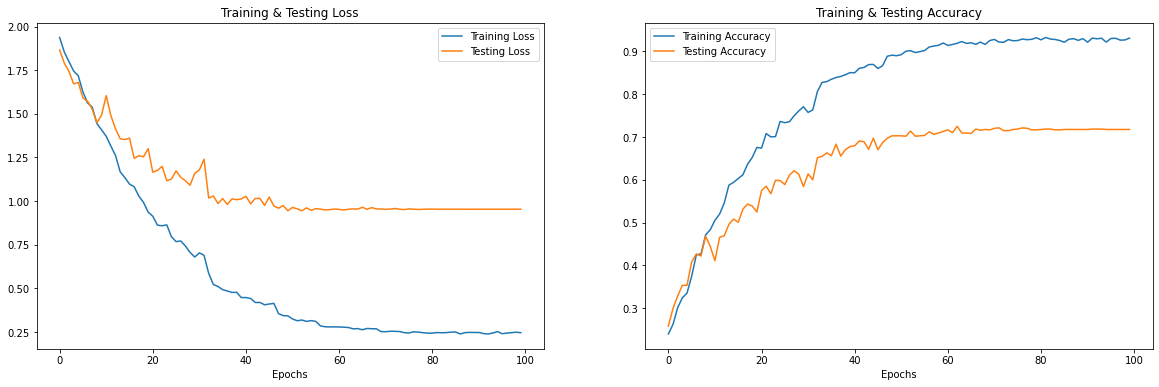

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(n_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 3ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(100)

,Predicted Labels,Actual Labels
0,calm,calm
1,disgust,disgust
2,surprise,surprise
3,calm,calm
4,disgust,disgust
...,...,...
95,angry,angry
96,neutral,neutral
97,disgust,disgust
98,disgust,disgust


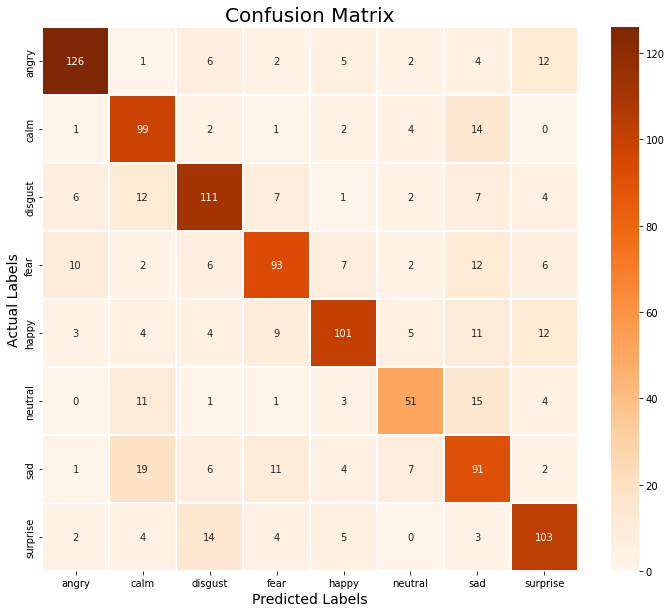

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Oranges', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.85      0.80      0.82       158
        calm       0.65      0.80      0.72       123
     disgust       0.74      0.74      0.74       150
        fear       0.73      0.67      0.70       138
       happy       0.79      0.68      0.73       149
     neutral       0.70      0.59      0.64        86
         sad       0.58      0.65      0.61       141
    surprise       0.72      0.76      0.74       135

    accuracy                           0.72      1080
   macro avg       0.72      0.71      0.71      1080
weighted avg       0.72      0.72      0.72      1080



In [ ]:
# model.save('/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/SER4/model.h5')